In [24]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from __future__ import print_function
from sklearn import preprocessing
from time import time
# from sklearn.cross_validation import train_test_split
# from sklearn.grid_search import GridSearchCV
# from sklearn.metrics import classification_report
# from sklearn.svm import SVC
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge
import numpy as np
import sklearn.decomposition
import sklearn.metrics
from sklearn import gaussian_process
from sklearn import cross_validation
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.ensemble import RandomForestClassifier

np.random.seed(1234)

#load 2015 and 2016 data into train and test data set 
horseData2015 = np.array(pd.read_excel('Horse2015.xlsx').values)
horseData2015 = np.vstack({tuple(row) for row in horseData2015})

horseData2016 = np.array(pd.read_excel('Horse2016.xlsx').values)
horseData2016 = np.vstack({tuple(row) for row in horseData2016})

x_train = horseData2015[:, :-1];
y_train = horseData2015[:, -1:horseData2015[0].size];

x_test = horseData2016[:, :-1];
y_test = horseData2016[:, -1:horseData2016[0].size];

#smoooth y for both training and testing data
y_train = y_train.reshape(len(y_train),).astype(int) + (np.random.random_sample((len(y_train),))-1) + np.random.random_sample((len(y_train),))
y_test = y_test.reshape(len(y_test),).astype(int) + (np.random.random_sample((len(y_test),))-1) + np.random.random_sample((len(y_test),))

#smooth x_train for grid_search
X_train_smooth = preprocessing.scale(x_train)

param_grid = {"theta0": [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07],
              "nugget": [0.01, 0.02, 0.03]}

clf = gaussian_process.GaussianProcess()
# print(clf.get_params().keys())
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X_train_smooth, y_train)

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

report(grid_search.cv_results_)



    


GridSearchCV took 0.29 seconds for 32 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.654 (std: 0.031)
Parameters: {'nugget': 0.08, 'theta0': 0.03}

Model with rank: 2
Mean validation score: 0.653 (std: 0.024)
Parameters: {'nugget': 0.08, 'theta0': 0.02}

Model with rank: 3
Mean validation score: 0.651 (std: 0.025)
Parameters: {'nugget': 0.03, 'theta0': 0.03}



Train score R2: 0.920627568841
Test score R2: 0.435601822849


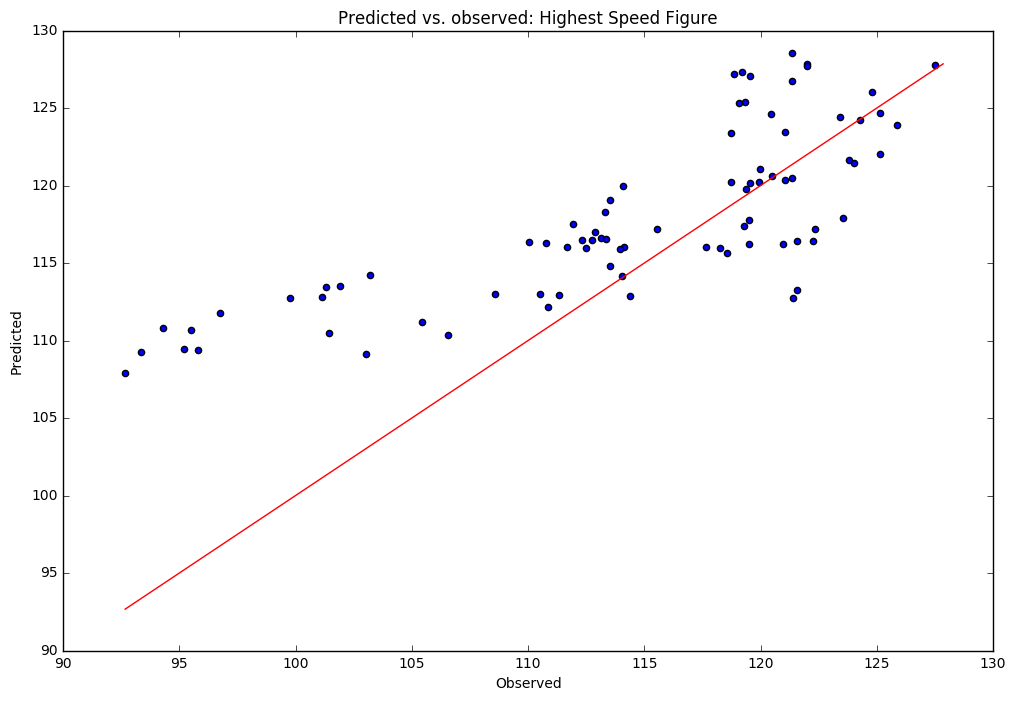

[ 133.1398816   120.35492432  124.22390764  116.03569408  115.95522274
  116.45405407  133.2293195   113.49749347  133.22554961  116.6173497
  117.39649868  109.1191418   120.24991774  127.09211068  115.97258576
  116.38739132  122.06251606  117.78775235  112.7216317   119.76338451
  114.13490288  123.44027478  112.97379561  117.90370846  109.22833561
  109.48153744  116.48277669  110.3598374   116.03105688  126.73338147
  117.01616109  124.69419315  113.00856638  117.49490809  120.63777117
  119.95450743  127.16139403  109.4016672   117.18316894  124.39504704
  126.00911056  107.91946203  116.19483006  127.77025776  110.68443436
  111.80383429  112.91458457  130.67376903  127.86308903  127.71239666
  120.24214231  117.19085986  116.38711116  121.07396832  112.7575696
  116.56023312  125.3575926   118.28347116  116.31954041  116.05467029
  110.47349803  112.1737986   125.31857307  116.22560591  115.61747863
  127.35224387  111.17275487  123.88322494  123.36356311  128.57923743
  120.18

In [39]:
def predictAll(theta, nugget, trainX, trainY, testX, testY, testSet, title):

    gp = gaussian_process.GaussianProcess(theta0=theta, nugget =nugget)
    gp.fit(trainX, trainY)

    predictedY, MSE = gp.predict(testX, eval_MSE = True)
    sigma = np.sqrt(MSE)
    
    results = {}
    results['predictedY'] = predictedY
    results['sigma'] = sigma

    print ("Train score R2:", gp.score(trainX, trainY))
    print ("Test score R2:", sklearn.metrics.r2_score(testY, predictedY))

    plt.figure(figsize = (12,8))
    plt.scatter(testY, predictedY)
    plt.plot([min(testY), max(testY)], [min(testY), max(testY)], 'r')
    plt.xlim(90, 130)
    plt.ylim(90, 130)
#     plt.xlim([min(testY)[0], max(testY)[0]])
#     plt.ylim([min(testY)[0], max(testY)[0]])
    plt.title('Predicted vs. observed: ' + title)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    plt.show()
    
    return gp, results

gp, results = predictAll(0.01, 0.03, x_train, y_train, 
                                  x_test, y_test, x_test, 'Highest Speed Figure')

def calculateError(predict, actual) :
    total =0.0
    for i in range(len(predict)):
        total += predict[i] - actual[i]
    return total/len(predict)
            
err = calculateError(results['predictedY'],y_test)
print(err)
